In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
# %matplotlib qt
#解决第二次提交的问题：输出的视频卡顿住在开始处
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

Text(0.5, 1.0, 'Undistorted Image')

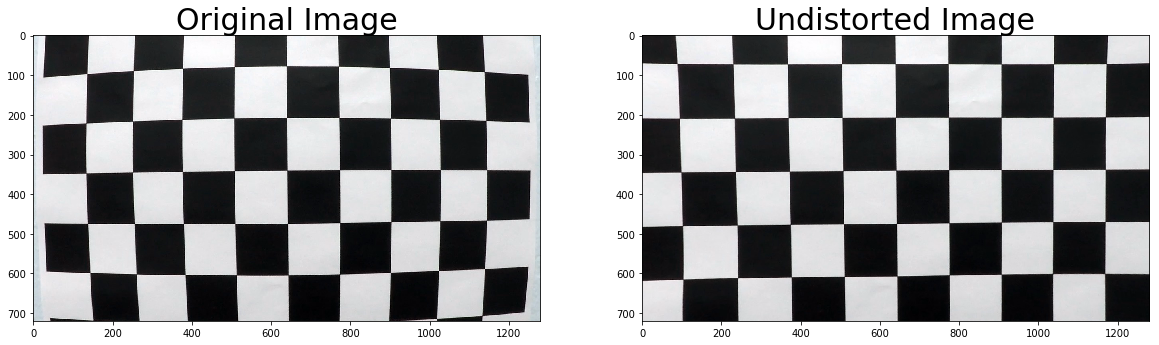

In [2]:
# img = cv2.imread("../Practice/test_image.jpg")   #不能用这张图片进行图片矫正，因为在12.01中 objp = np.zeros((6*8,3), np.float32)，矫正点的个数不相同
%matplotlib inline
import pickle

img = cv2.imread("../Practice/calibration1.jpg")
img_size = (img.shape[1],img.shape[0])

# ret,mtx,dist,rvecs,tvecs = cv2.calibrateCamera(objpoints,imgpoints,img_size,None,None)

# dst = cv2.undistort(img,mtx,dist,None,mtx)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

# dist_pickle = {}
# dist_pickle["mtx"] = mtx
# dist_pickle["dist"] = dist

# print(img_size)

dst = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

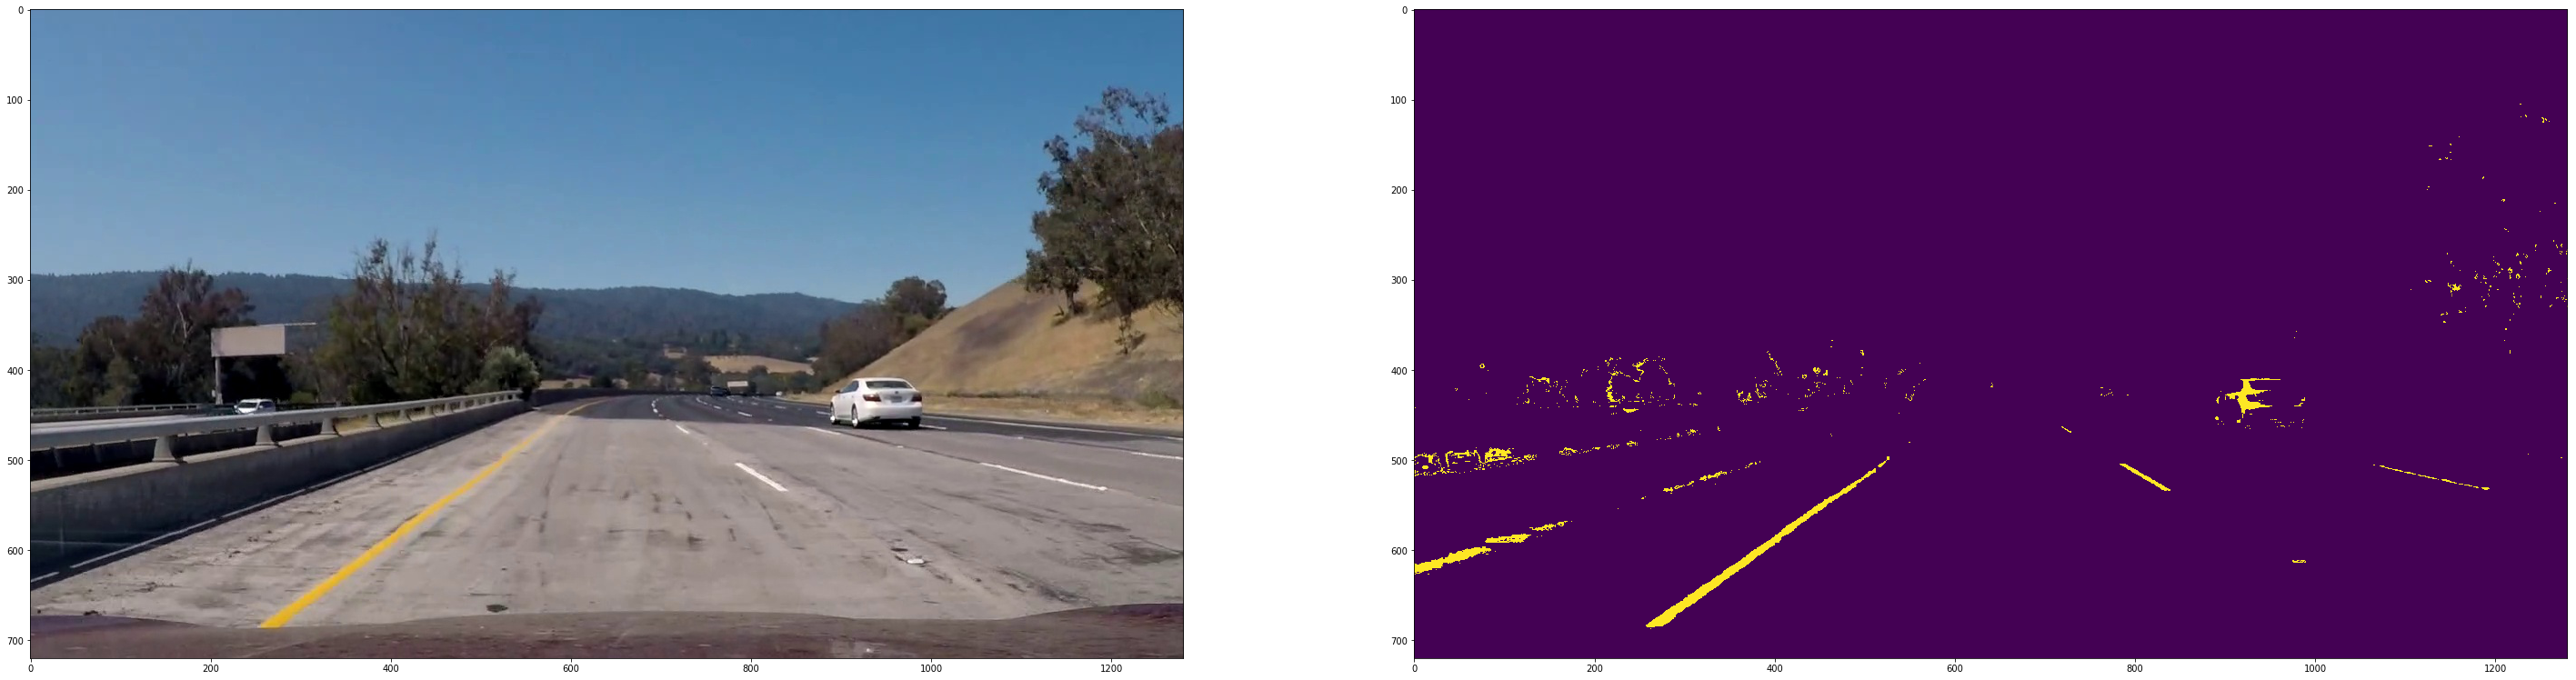

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# img = mpimg.imread("../Practice/test6.jpg")
# img = mpimg.imread("straight_lines1.jpg")
img = mpimg.imread("591.jpg")
def threshold_image(img,s_thresh = (140,255),Sob_thresh = (20,251),b_thresh = (195,255),l_thresh = (220,255)):
    img = np.copy(img)
    
    hls = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    lab = cv2.cvtColor(img,cv2.COLOR_BGR2LAB)
    
    l = hls[:,:,1]
    s = hls[:,:,2]
    
    b = lab[:,:,2]
    
    r = img[:,:,0]
    #####################################对应于lab
    lab_b = np.uint8(255*b/np.max(b))
    
    lab_output = np.zeros_like(lab_b)
    lab_output[(lab_b >b_thresh[0])&(lab_b < b_thresh[1])] = 1
    #######################################对应于sobelx
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0)
    abs_sobels = np.abs(sobelx)
    scaled_sobel = np.uint8(255*abs_sobels/np.max(abs_sobels))
    
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel>Sob_thresh[0])&(scaled_sobel<Sob_thresh[1])] = 1
    #####################################对应于HLS中的S
    sbinary = np.zeros_like(s)     
    sbinary[(s>s_thresh[0])&(s<s_thresh[1])] = 1
    #####################################对应于HLS中的L
    lbinary = np.zeros_like(l)
    lbinary[(l>l_thresh[0])&(l<l_thresh[1])] = 1
    #####################################对应于RGB
    rgb_r = np.zeros_like(r)
    rgb_r[(rgb_r<255)&(rgb_r>100)] = 1
    
    
    
    combined_binary = np.zeros_like(sxbinary)
#
#     combined_binary[(sbinary == 1)|(lab_output == 1)|(lbinary == 1)] = 255
    combined_binary[(sbinary == 1)|(lbinary == 1)] = 255
    return combined_binary

result = threshold_image(img)
f,(ax1,ax2) = plt.subplots(1,2,figsize = (50,25))
ax1.imshow(img)
ax2.imshow(result)

In [4]:
# %matplotlib qt
%matplotlib inline
img = mpimg.imread("591.jpg")
def warped_image(img):
    img_size = (img.shape[1],img.shape[0])
#   
    src = np.float32([[576.475,460.555],
                      [705.625,460.555],
                      [1038.31,674.427],
                      [271.681,674.427]])
    
    dst = np.float32([[400,100],
                      [850,100],
                      [850,720],
                      [400,720]])
    
    M = cv2.getPerspectiveTransform(src,dst)
    
    Warp = cv2.warpPerspective(img,M,img_size,flags = cv2.INTER_LINEAR)   #注意和7.18第一个cell中的第50行比较
    return Warp

# warped_result = warped_image(img)
# binary_image = threshold_image(warped_result)

# f,(ax1,ax2,ax3) = plt.subplots(1,3,figsize = (25,9))
# ax1.imshow(img)
# ax2.imshow(warped_result)
# ax3.imshow(binary_image)

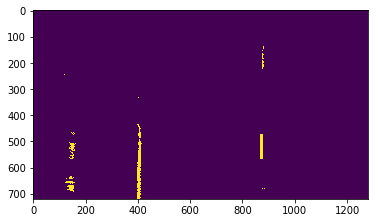

In [5]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)  #直方图是二维矩阵的y轴之和，即是说将沿y轴压扁，那么shape的一半指的是沿x轴的一半
    leftx_base = np.argmax(histogram[:midpoint])

    rightx_base = np.argmax(histogram[midpoint:]) + midpoint #因为np.argmax(histogram[midpoint:])输出的矩阵会以midpoint为0重新排布成一个新的索引
    #，所以加上0使得righttx_base 这个索引值按照原索引输出

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 7
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero_1 = binary_warped.nonzero()
   
    nonzeroy = np.array(nonzero_1[0])

    nonzerox = np.array(nonzero_1[1])

    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height

        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2)            #255指的是绿色
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]   #满足位置条件的非零点（x,y）的新索引值 

        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))    #这些点中x坐标（索引）的均值
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))  #这些点y坐标（索引）的均值

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)

        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    thriple_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(thriple_img)
    
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)  #拟合lefty和leftx得到二级多项式

    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )

    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
       
    left_bundary = np.array([np.transpose(np.vstack([left_fitx,ploty]))])
    right_bundary = np.array([np.flipud(np.transpose(np.vstack([right_fitx,ploty])))])
    
    mask = np.hstack((left_bundary,right_bundary))
    
    cv2.fillPoly(window_img,np.int_([mask]),(0,255,0))

    ## Visualization ##
    # Colors in the left and right lane regions

    # Plots the left and right polynomials on the lane lines
#     plt.plot(left_fitx, ploty, color='red')
#     plt.plot(right_fitx, ploty, color='red')
    
    return window_img

warped_result = warped_image(img)
binary_image = threshold_image(warped_result)
plt.imshow(binary_image)
out_img = fit_polynomial(binary_image)
# plt.imshow(out_img)

result = cv2.addWeighted(warped_result,1,out_img,0.3,0)
# plt.imshow(result)                                     #  158行与160行分别表示在二值图和彩图上绘制曲线

In [6]:
def measure_curvature_pixels(image):
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(image)

    ym_per_pix = 30/720 
    xm_per_pix = 3.7/700
    
    ploty = np.linspace(0,image.shape[0]-1,image.shape[0])
    left_fit = np.polyfit(lefty*ym_per_pix,leftx*xm_per_pix,2)
    right_fit = np.polyfit(righty*ym_per_pix,rightx*xm_per_pix,2)
    
    valy = np.max(ploty)
    left_curverad = ((1+(2*left_fit[0]*valy*ym_per_pix+left_fit[1]**2))**1.5)/np.absolute(2*left_fit[0])
    right_curverad = ((1+(2*right_fit[0]*valy*ym_per_pix+right_fit[1]**2))**1.5)/np.absolute(2*right_fit[0])
    
    position_left_x = left_fit[0]*valy**2 + left_fit[1]*valy + left_fit[2]   #使用第8行代码，则数值为426.24445018677与上个cell一致
    
    val_left_x = left_fit[0]*(valy*ym_per_pix)**2 + valy*ym_per_pix*left_fit[1] + left_fit[2]  

    val_right_x = right_fit[0]*(valy*ym_per_pix)**2 + valy*ym_per_pix*right_fit[1] + right_fit[2]
    center = np.mean([val_left_x,val_right_x])
    length = image.shape[1] * xm_per_pix / 2

    return left_curverad,right_curverad,center,length

def position_calculate(center,length):
    if(center - length) > 0:
        a = center - length
#         print("Vehicle is {}m left of center".format(round(a,2)))
#         plt.text(100,100,"Come on ! popov take you to enjoy the fluctuate journey !",color = "w",alpha = 0.6)
#         plt.text(100,150,"Vehicle is {}m left of center".format(round(a,2)),color = "w",alpha = 0.6)
    elif(center - length) == 0:
        a = center - length
#         print("Vehicle is in center")
#         plt.text(100,100,"Come on ! popov take you to enjoy the fluctuate journey",color = "w",alpha = 0.6)
#         plt.text(100,150,"Vehicle is {}m left of center".format(round(a,2)),color = "w",alpha = 0.6)
    else:
        a = length - center
#         print("Vehicle is {}m right of center".format(round(a,2)))
#         plt.text(100,100,"Come on ! popov take you to enjoy the fluctuate journey",color = "w",alpha = 0.6)
#         plt.text(100,150,"Vehicle is {}m left of center".format(round(a,2)),color = "w",alpha = 0.6)
    return a

def print_position(binary_image):
    cur_left,cur_right,center,length = measure_curvature_pixels(binary_image)
    cur = np.mean([cur_left,cur_right])  
#     print("the value of curvature is:",cur)
    a = position_calculate(center,length)
    return a,cur

# print_position(binary_image)

In [7]:
def warped_back_image(img):
    img_size = (img.shape[1],img.shape[0])
#     plt.imshow(img)
    src = np.float32([[576.475,460.555],
                      [705.625,460.555],
                      [1038.31,674.427],
                      [271.681,674.427]])
    
    dst = np.float32([[400,100],
                      [850,100],
                      [850,720],
                      [400,720]])
    
    M = cv2.getPerspectiveTransform(dst,src)
    
    Warp = cv2.warpPerspective(img,M,img_size,flags = cv2.INTER_LINEAR)   #注意和7.18第一个cell中的第50行比较
    return Warp

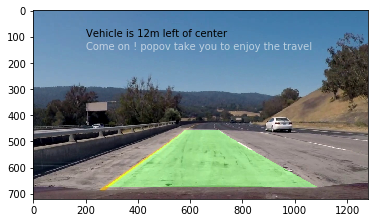

In [8]:
# from PIL import ImageFont, Image, ImageDraw
img = mpimg.imread("591.jpg")

warped_result = warped_image(img)
binary_image = threshold_image(warped_result)
out_img = fit_polynomial(binary_image)

warped_back_result = warped_back_image(out_img)
# plt.imshow(warped_back_result)

result = cv2.addWeighted(warped_back_result,0.3,img,1,0)
plt.imshow(result)

plt.text(200,150,"Come on ! popov take you to enjoy the travel",color = "w",alpha = 0.6)
plt.text(200, 100,"Vehicle is {}m left of center".format(round(12,20)))

warped_back_img = warped_back_image(result)
true_img = cv2.addWeighted(img,1,warped_back_img,1,0)
# f,(ax1,ax2,ax3) =  plt.subplots(1, 3, sharey='col', sharex='row', figsize=(10,4))
# ax1.imshow(warped_back_img)
# ax2.imshow(true_img)
# ax3.imshow(img)

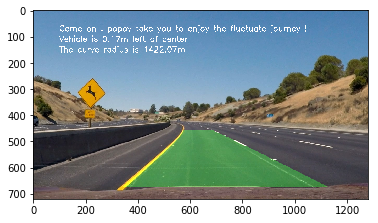

In [18]:
# from PIL import Image
def process_image(img):
    result = threshold_image(img)
    
    warped_result = warped_image(img)
    binary_image = threshold_image(warped_result)
    out_img = fit_polynomial(binary_image)
    
    a,cur = print_position(binary_image)
    
    warped_back_result = warped_back_image(out_img)
    
    result = cv2.addWeighted(warped_back_result,0.3,img,1,0)
    
#     plt.text(100,100,"Come on ! popov take you to enjoy the fluctuate journey !",color = "w",alpha = 0.6)
#     plt.text(100,150,"Vehicle is {}m left of center".format(round(a,2)),color = "w",alpha = 0.6)
#     plt.text(100,200,"The curve radius is {}m".format(round(cur,2)),color = "w",alpha = 0.6)
    cv2.putText(result,"Come on ! popov take you to enjoy the fluctuate journey !".format(round(cur,2)),(100,80),fontFace = 16, fontScale = 1, color=(255,255,255), thickness = 2)
    cv2.putText(result,"Vehicle is {}m left of center".format(round(a,2)),(100,120),fontFace = 16, fontScale = 1, color=(255,255,255), thickness = 2)
    cv2.putText(result,"The curve radius is {}m".format(round(cur,2)),(100,160),fontFace = 16, fontScale = 1, color=(255,255,255), thickness = 2)
    
#     true_img = cv2.addWeighted(img,1,warped_back_img,1,0)
#     plt.imshow(true_img)
#     new_im = Image.fromarray(true_img.astype(np.uint8))
    return result

img = mpimg.imread("test2.jpg")
plt.imshow(process_image(img))

In [19]:
import os
os.listdir("test_images/")

['straight_lines1.jpg',
 'straight_lines2.jpg',
 'test1.jpg',
 'test2.jpg',
 'test3.jpg',
 'test4.jpg',
 'test5.jpg',
 'test6.jpg']

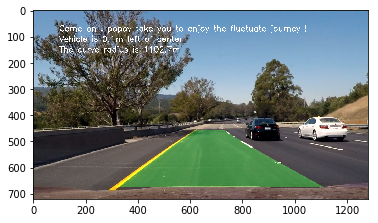

In [20]:
import glob

for file in glob.glob(os.path.join("test_images/","*.jpg")):
    im = mpimg.imread(file)
    proim = process_image(im)
    '''
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
    ax1.imshow(cv2.cvtColor(mpimg.imread(fname), cv2.COLOR_BGR2RGB))
    ax1.set_title('Original Image', fontsize=18)
    ax2.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    ax2.set_title('With Corners', fontsize=18)
    '''
    plt.imshow(proim)

In [21]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [25]:
white_output = '../chanllenge1_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
# clip1 = VideoFileClip("../project_video.mp4")
clip1 = VideoFileClip("../challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!       #用fl_image函数将原图片替换为修改后的图片,用于传递物体识别的每张抓取图片
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ../chanllenge1_video_output.mp4
[MoviePy] Writing video ../chanllenge1_video_output.mp4



  1%|█                                                                                 | 6/485 [00:01<01:51,  4.31it/s]

TypeError: expected non-empty vector for x

In [24]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))